In [1]:
import sys
import random
import pandas as pd
import pathlib
import csv
import matplotlib.pyplot as plt
import dataclasses
from scipy import stats

from insurance_claims import fbp_app_min, record_types

In [2]:
insurance_claims_data = pd.read_csv("insurance_claims/insurance_claims.csv")

### Some initial analysis of insurance claims

Skew the input distirbution and see what will happen to the output

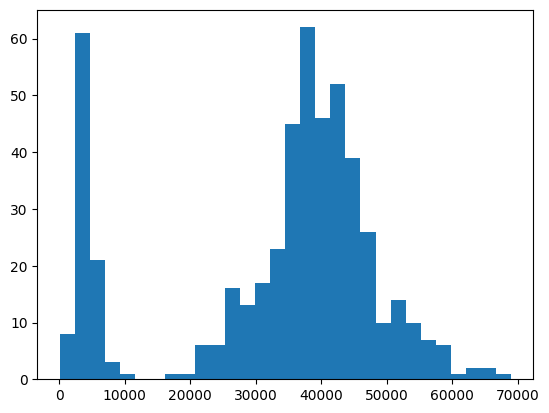

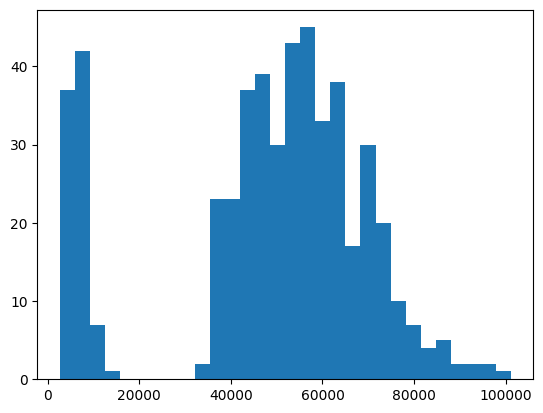

In [3]:
#################  ######################

input_data_df = insurance_claims_data.copy()
input_data_df['claim_id'] = input_data_df.index
input_data = input_data_df.to_dict(orient='records')

n_claims = 500
input_records = input_data_df.sample(n=n_claims).to_dict(orient='records')

app = fbp_app_min.App()
app.add_data(input_records)
output = app.evaluate()
claim_payouts = [x.payout for x in output]

plt.hist(claim_payouts, bins=30);
plt.show()



skewed_claim_payouts = []
input_records_df = input_data_df.sample(n=n_claims)
input_records_df["total_claim_amount"] = input_records_df["total_claim_amount"] * 1.5
input_records = input_records_df.to_dict(orient='records')

app = fbp_app_min.App(with_bug=True)
app.add_data(input_records)
output = app.evaluate()
skewed_claim_payouts = [x.payout for x in output]

plt.hist(skewed_claim_payouts, bins=30);

### Dataset generation routines

In [4]:
n_claims = 500

nodes = [("NewClaimsStream", "total_claim_amount"), ("ClaimValueStream", "value"),
         ("HighValueClaimsStream", "total_claim_amount"), ("LowValueClaimsStream", "total_claim_amount"),
         ("SimpleClaimsStream", "total_claim_amount"), ("ComplexClaimsStream", "total_claim_amount"),
         ("ClaimPayoutStream", "payout")]

In [5]:
def generate_dataset(app, input_records):
    app.add_data(input_records)
    output = app.evaluate();
    claim_ids = [x.claim_id for x in output];

    dataset = {node[0]:[] for node in nodes}
    for node_name, value_name in nodes:
        node = next(node for node in app.graph.nodes if node_name == node.name)
        if node.data is None or len(node.data) == 0:
            data = []
        elif isinstance(node.data[0], dict):
            data = node.data
        else:
            data = [dataclasses.asdict(x) for x in node.data]
        
        for claim_id in claim_ids:
            node_record = next((record for record in data if record["claim_id"] == claim_id), None)
            if node_record is None:
                dataset[node_name].append(None)
            else:
                dataset[node_name].append(node_record[value_name])

    return pd.DataFrame(dataset)

In [6]:
# normal data, normal app
input_data_df = insurance_claims_data.sample(n=n_claims)
input_data_df['claim_id'] = input_data_df.index
input_data = input_data_df.to_dict(orient='records')

app = fbp_app_min.App()

normal_df = generate_dataset(app, input_data)
normal_df = normal_df.fillna(0)


# broken data, normal app
input_data_df = insurance_claims_data.sample(n=n_claims)
input_data_df['claim_id'] = input_data_df.index
input_data_df["total_claim_amount"] = input_data_df["total_claim_amount"] * 1.5
input_data = input_data_df.to_dict(orient='records')

app = fbp_app_min.App()

broken_data_df = generate_dataset(app, input_data)
broken_data_df = broken_data_df.fillna(0)


# broken app, normal data
input_data_df = insurance_claims_data.sample(n=n_claims)
input_data_df['claim_id'] = input_data_df.index
input_data = input_data_df.to_dict(orient='records')

app = fbp_app_min.App(with_bug=True)

broken_app_df = generate_dataset(app, input_data)
broken_app_df = broken_app_df.fillna(0)


# broken app, broken data
input_data_df = insurance_claims_data.sample(n=n_claims)
input_data_df['claim_id'] = input_data_df.index
input_data_df["total_claim_amount"] = input_data_df["total_claim_amount"] * 1.5
input_data = input_data_df.to_dict(orient='records')

broken_app = fbp_app_min.App(with_bug=True)

broken_all_df = generate_dataset(app, input_data)
broken_all_df = broken_all_df.fillna(0)


### Causal graphs

Define causal graph and models, run first experiments for each way of breaking things

In [7]:
import networkx as nx, numpy as np, pandas as pd
from dowhy import gcm

In [8]:
causal_graph = nx.DiGraph([
    ('NewClaimsStream', 'ClaimValueStream'),
    ('NewClaimsStream', 'HighValueClaimsStream'),
    ('NewClaimsStream', 'LowValueClaimsStream'),
    ('ClaimValueStream', 'HighValueClaimsStream'),
    ('ClaimValueStream', 'LowValueClaimsStream'),
    
    ('HighValueClaimsStream', 'ComplexClaimsStream'),
    ('LowValueClaimsStream', 'ComplexClaimsStream'),
    ('LowValueClaimsStream', 'SimpleClaimsStream'),

    ('ComplexClaimsStream', 'ClaimPayoutStream'),
    ('SimpleClaimsStream', 'ClaimPayoutStream'),
])

#### Broken data example

In [9]:
causal_model = gcm.ProbabilisticCausalModel(causal_graph)
causal_model.set_causal_mechanism('NewClaimsStream', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('ClaimValueStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('HighValueClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('LowValueClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('ComplexClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('SimpleClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('ClaimPayoutStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

attributions = gcm.distribution_change(causal_model, normal_df, broken_data_df, 'ClaimPayoutStream')

Estimating Shapley Values. Average change of Shapley values in run 6 (30 evaluated permutations): -65.63794051545582%: 100%|██████████| 1/1 [00:05<00:00,  5.33s/it]


In [10]:
print("Attributions:")
print(attributions)
print()
abs_attrs = [abs(x) for x in attributions.values()]
probs = [abs(x)/sum(abs_attrs) for x in abs_attrs]
print("Probabilities, same order:")
print(probs)

Attributions:
{'ClaimPayoutStream': -0.0018396010587539416, 'ClaimValueStream': -0.0019077595216776806, 'ComplexClaimsStream': 0.0017604140989661461, 'HighValueClaimsStream': -0.0002949374949290817, 'LowValueClaimsStream': -0.0017366531872206566, 'NewClaimsStream': 0.22790511788045703, 'SimpleClaimsStream': -0.00500074196463271}

Probabilities, same order:
[0.0076508113528684085, 0.007934279085967139, 0.007321476637572055, 0.0012266307000923563, 0.007222656160995449, 0.9478463033923701, 0.020797842670134542]


#### Broken app example

In [11]:
causal_model = gcm.ProbabilisticCausalModel(causal_graph)
causal_model.set_causal_mechanism('NewClaimsStream', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('ClaimValueStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('HighValueClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('LowValueClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('ComplexClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('SimpleClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('ClaimPayoutStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

attributions = gcm.distribution_change(causal_model, normal_df, broken_app_df, 'ClaimPayoutStream')

Estimating Shapley Values. Average change of Shapley values in run 19 (95 evaluated permutations): 0.20922796578752367%: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


In [12]:
print("Attributions:")
print(attributions)
print()
abs_attrs = [abs(x) for x in attributions.values()]
probs = [abs(x)/sum(abs_attrs) for x in abs_attrs]
print("Probabilities, same order:")
print(probs)

Attributions:
{'ClaimPayoutStream': 0.00020047697338355334, 'ClaimValueStream': 0.0024614099168667764, 'ComplexClaimsStream': -0.003308747471054228, 'HighValueClaimsStream': 0.001273297691254102, 'LowValueClaimsStream': 0.0032123295904538827, 'NewClaimsStream': 0.0012935802414351717, 'SimpleClaimsStream': 0.026852163060389237}

Probabilities, same order:
[0.005193434218508572, 0.06376378430043157, 0.08571439425963742, 0.03298527351296054, 0.08321665144192295, 0.033510700889337844, 0.695615761377201]


#### Broken data and app example

In [13]:
causal_model = gcm.ProbabilisticCausalModel(causal_graph)
causal_model.set_causal_mechanism('NewClaimsStream', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('ClaimValueStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('HighValueClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('LowValueClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('ComplexClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('SimpleClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('ClaimPayoutStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

attributions = gcm.distribution_change(causal_model, normal_df, broken_all_df, 'ClaimPayoutStream')

Estimating Shapley Values. Average change of Shapley values in run 17 (85 evaluated permutations): 0.02508094677764313%: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


In [14]:
print("Attributions:")
print(attributions)
print()
abs_attrs = [abs(x) for x in attributions.values()]
probs = [abs(x)/sum(abs_attrs) for x in abs_attrs]
print("Probabilities, same order:")
print(probs)

Attributions:
{'ClaimPayoutStream': 0.0014802271567108051, 'ClaimValueStream': -0.0013124383218067076, 'ComplexClaimsStream': -0.015714423602697532, 'HighValueClaimsStream': -0.0001702037895452122, 'LowValueClaimsStream': -0.00258127578747575, 'NewClaimsStream': 0.07736748207173781, 'SimpleClaimsStream': 0.013478086687012971}

Probabilities, same order:
[0.013204036807356146, 0.01170731386054836, 0.14017701723394532, 0.0015182650120406861, 0.023025695990811997, 0.6901393994403506, 0.12022827165494676]


### Repeated experiments

In [15]:
def full_experiment(break_data=False, break_app=False):
    # normal data, normal app
    input_data_df = insurance_claims_data.sample(n=n_claims)
    input_data_df['claim_id'] = input_data_df.index
    input_data = input_data_df.to_dict(orient='records')

    app = fbp_app_min.App()

    normal_df = generate_dataset(app, input_data)
    normal_df = normal_df.fillna(0)


    # broken app or data
    input_data_df = insurance_claims_data.sample(n=n_claims)
    input_data_df['claim_id'] = input_data_df.index
    if break_data:
        input_data_df["total_claim_amount"] = input_data_df["total_claim_amount"] * 1.5
    input_data = input_data_df.to_dict(orient='records')
    app = fbp_app_min.App(with_bug=break_app)

    broken_df = generate_dataset(app, input_data)
    broken_df = broken_df.fillna(0)


    # compute attributions
    causal_model = gcm.ProbabilisticCausalModel(causal_graph)
    causal_model.set_causal_mechanism('NewClaimsStream', gcm.EmpiricalDistribution())
    causal_model.set_causal_mechanism('ClaimValueStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    causal_model.set_causal_mechanism('HighValueClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    causal_model.set_causal_mechanism('LowValueClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    causal_model.set_causal_mechanism('ComplexClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    causal_model.set_causal_mechanism('SimpleClaimsStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    causal_model.set_causal_mechanism('ClaimPayoutStream', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

    attributions = gcm.distribution_change(causal_model, normal_df, broken_df, 'ClaimPayoutStream')

    return attributions


def repeat_experiment(break_data=False, break_app=False, n_repeats=10):
    attributions_per_experiment = []
    for _ in range(n_repeats):
        attributions = full_experiment(break_data, break_app)
        attributions_per_experiment.append(attributions)
    
    return pd.DataFrame(attributions_per_experiment)

#### Broken app

In [16]:
broken_app_attr_df = repeat_experiment(break_data=False, break_app=True, n_repeats=30)
broken_app_attr_df.abs().divide(broken_app_attr_df.abs().sum(axis='columns'), axis='rows')

Estimating Shapley Values. Average change of Shapley values in run 9 (45 evaluated permutations): -6.25059432738357%: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]
Estimating Shapley Values. Average change of Shapley values in run 4 (20 evaluated permutations): -2.860629940822079%: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
Estimating Shapley Values. Average change of Shapley values in run 17 (85 evaluated permutations): -0.010948704596095269%: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
Estimating Shapley Values. Average change of Shapley values in run 5 (25 evaluated permutations): -38.99927444479586%: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
Estimating Shapley Values. Average change of Shapley values in run 25 (125 evaluated permutations): -25.661181118288273%: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
Estimating Shapley Values. Average change of Shapley values in run 3 (15 evaluated permutations): -13.505774486830449%: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
Est

,ClaimPayoutStream,ClaimValueStream,ComplexClaimsStream,HighValueClaimsStream,LowValueClaimsStream,NewClaimsStream,SimpleClaimsStream
0,0.028794,0.086343,0.252788,0.064881,0.034601,0.019450,0.513142
1,0.051322,0.109752,0.305838,0.210296,0.053443,0.031043,0.238305
2,0.227608,0.018115,0.053130,0.085547,0.085659,0.100102,0.429838
3,0.024619,0.179802,0.093974,0.041426,0.052946,0.010688,0.596546
4,0.133887,0.017613,0.160928,0.102262,0.039525,0.127866,0.417920
5,0.051213,0.076959,0.103317,0.031900,0.054011,0.014515,0.668085
6,0.008716,0.030138,0.354271,0.115591,0.001006,0.019165,0.471113
7,0.072574,0.113511,0.550030,0.117475,0.026645,0.106285,0.013481
8,0.021481,0.063639,0.364655,0.027127,0.152118,0.024873,0.346108
9,0.057397,0.017720,0.098555,0.022671,0.092766,0.014697,0.696193


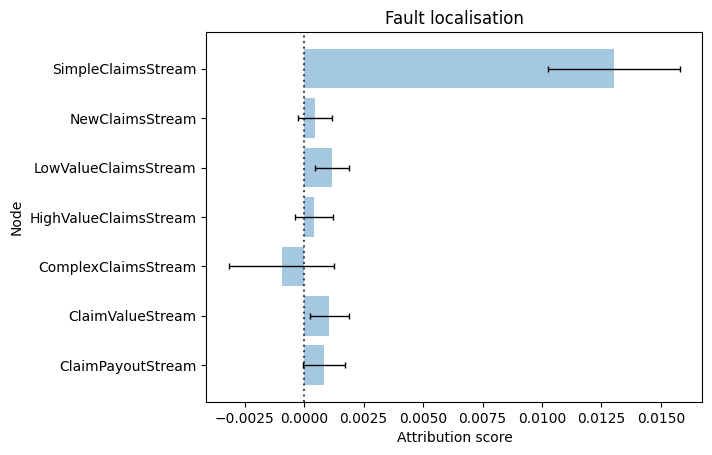

In [24]:
import math
count = broken_app_attr_df.shape[0]
means = broken_app_attr_df.mean(axis=0).to_list()
std = broken_app_attr_df.std(axis=0).to_list()
columns = broken_app_attr_df.columns.to_list()

ci95_lower = []
ci95_range = []
for m, s in zip(means, std):
    lower = m - 1.96*s/math.sqrt(count)
    ci95_lower.append(lower)
    ci95_range.append(m - lower)

import matplotlib.pyplot as plt

plt.barh(range(len(means)), means, xerr=ci95_range, alpha=0.4, align='center', error_kw={'capsize':2, 'elinewidth':1})
plt.yticks(range(len(means)), columns)
# plt.xscale('log')
plt.xlabel('Attribution score')
plt.ylabel('Node')
# plt.yticks(fontsize=12)
# plt.xscale('symlog', base=10, linscale=1000, linthresh=0.1)
# plt.xticks([-0.005, 0, 0.01])
plt.axvline(0, color='black', alpha=0.7, linestyle='dotted')
plt.title('Fault localisation')
plt.show()

In [34]:
for column in  broken_app_attr_df.columns:
    if column == "SimpleClaimsStream":
        continue
    
    test_result = stats.ttest_ind(broken_app_attr_df["SimpleClaimsStream"].to_list(),
                                  broken_app_attr_df[column].to_list(),
                                  equal_var=False)
    
    print(f"{column}: p-value = {test_result.pvalue}")

ClaimPayoutStream: p-value = 1.1007810084501695e-09
ClaimValueStream: p-value = 1.7199062140029015e-09
ComplexClaimsStream: p-value = 2.2629963131513525e-10
HighValueClaimsStream: p-value = 5.352224395813991e-10
LowValueClaimsStream: p-value = 2.2359323907276537e-09
NewClaimsStream: p-value = 5.956487591416205e-10


#### Broken data

In [27]:
broken_data_attr_df = repeat_experiment(break_data=True, break_app=False, n_repeats=30)
broken_data_attr_df.abs().divide(broken_data_attr_df.abs().sum(axis='columns'), axis='rows')

Estimating Shapley Values. Average change of Shapley values in run 9 (45 evaluated permutations): -4.50514912660417%: 100%|██████████| 1/1 [00:04<00:00,  4.55s/it]
Estimating Shapley Values. Average change of Shapley values in run 5 (25 evaluated permutations): -11.02375030523819%: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
Estimating Shapley Values. Average change of Shapley values in run 13 (65 evaluated permutations): -7.370289372224197%: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]
Estimating Shapley Values. Average change of Shapley values in run 12 (60 evaluated permutations): -11.201788878735153%: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
Estimating Shapley Values. Average change of Shapley values in run 13 (65 evaluated permutations): -7.424126392626343%: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
Estimating Shapley Values. Average change of Shapley values in run 4 (20 evaluated permutations): -60.45232345206829%: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]
Estimat

,ClaimPayoutStream,ClaimValueStream,ComplexClaimsStream,HighValueClaimsStream,LowValueClaimsStream,NewClaimsStream,SimpleClaimsStream
0,0.022148,0.005663,0.022711,0.278999,0.036459,0.632693,0.001327
1,0.016315,0.004872,0.129641,0.346798,0.046980,0.420033,0.035361
2,0.012878,0.033933,0.003883,0.030593,0.003727,0.906604,0.008383
3,0.009891,0.001955,0.031319,0.002283,0.018631,0.923415,0.012508
4,0.019967,0.004392,0.014525,0.302352,0.028469,0.626808,0.003487
5,0.005751,0.010541,0.018153,0.183086,0.009245,0.760416,0.012809
6,0.008065,0.000036,0.007632,0.028247,0.007093,0.934345,0.014582
7,0.032002,0.014736,0.001052,0.266081,0.086308,0.585033,0.014788
8,0.031777,0.011809,0.017656,0.002252,0.000951,0.913529,0.022026
9,0.010468,0.003199,0.000358,0.009609,0.023590,0.948871,0.003905


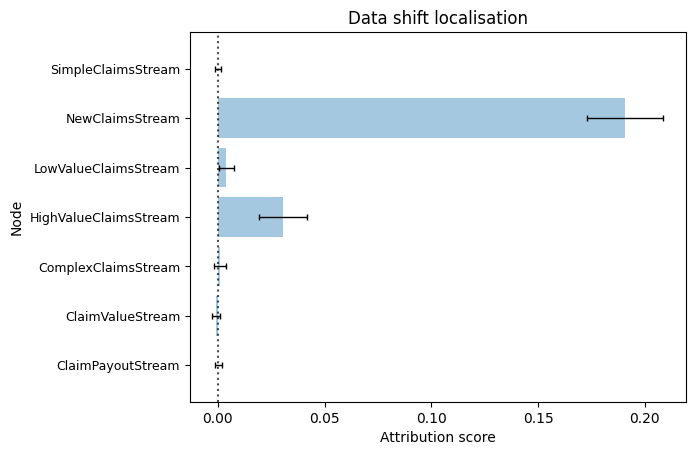

In [30]:
import math
count = broken_data_attr_df.shape[0]
means = broken_data_attr_df.mean(axis=0).to_list()
std = broken_data_attr_df.std(axis=0).to_list()
columns = broken_data_attr_df.columns.to_list()

ci95_lower = []
ci95_range = []
for m, s in zip(means, std):
    lower = m - 1.96*s/math.sqrt(count)
    ci95_lower.append(lower)
    ci95_range.append(m - lower)


import matplotlib.pyplot as plt

plt.barh(range(len(means)), means, xerr=ci95_range, alpha=0.4, align='center', error_kw={'capsize':2, 'elinewidth':1})
plt.yticks(range(len(means)), columns)
# plt.xscale('log')
plt.xlabel('Attribution score')
plt.ylabel('Node')
plt.yticks(fontsize=9)
# plt.xscale('symlog', base=10)
# plt.xticks([0, 0.1])
plt.axvline(0, color='black', alpha=0.7, linestyle='dotted')
plt.title('Data shift localisation')
plt.show()

In [33]:
for column in  broken_data_attr_df.columns:
    if column == "NewClaimsStream":
        continue
    
    test_result = stats.ttest_ind(broken_data_attr_df["NewClaimsStream"].to_list(),
                                  broken_data_attr_df[column].to_list(),
                                  equal_var=False)
    
    print(f"{column}: p-value = {test_result.pvalue}")

ClaimPayoutStream: p-value = 2.8969614088756763e-19
ClaimValueStream: p-value = 2.5121577669277603e-19
ComplexClaimsStream: p-value = 1.8251131166601131e-19
HighValueClaimsStream: p-value = 7.064444720086758e-20
LowValueClaimsStream: p-value = 1.551898143194559e-19
SimpleClaimsStream: p-value = 3.2340202002150296e-19


#### Broken data and app

In [22]:
broken_all_attr_df = repeat_experiment(break_data=True, break_app=True, n_repeats=10)
broken_all_attr_df.abs().divide(broken_all_attr_df.abs().sum(axis='columns'), axis='rows')

Estimating Shapley Values. Average change of Shapley values in run 10 (50 evaluated permutations): -2.3824916864481565%: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
Estimating Shapley Values. Average change of Shapley values in run 4 (20 evaluated permutations): -292.8123748245003%: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]
Estimating Shapley Values. Average change of Shapley values in run 13 (65 evaluated permutations): -8.221619669703324%: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
Estimating Shapley Values. Average change of Shapley values in run 10 (50 evaluated permutations): -1.101137971319978%: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]
Estimating Shapley Values. Average change of Shapley values in run 6 (30 evaluated permutations): -26.84436269197078%: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
Estimating Shapley Values. Average change of Shapley values in run 6 (30 evaluated permutations): -40.286692492634195%: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
Estim

,ClaimPayoutStream,ClaimValueStream,ComplexClaimsStream,HighValueClaimsStream,LowValueClaimsStream,NewClaimsStream,SimpleClaimsStream
0,0.020561,0.007931,0.092496,0.215167,0.052118,0.436649,0.175078
1,0.011397,0.007256,0.021652,0.021882,0.002679,0.753831,0.181305
2,0.033100,0.000958,0.004613,0.009884,0.004284,0.794648,0.152514
3,0.016364,0.001769,0.102431,0.267439,0.050593,0.368433,0.192971
4,0.003250,0.008670,0.020420,0.009833,0.007525,0.854764,0.095538
5,0.007241,0.001195,0.154966,0.244738,0.035857,0.311836,0.244167
6,0.002808,0.005336,0.160886,0.256523,0.016182,0.381749,0.176516
7,0.057934,0.035202,0.043384,0.034041,0.010397,0.711882,0.107160
8,0.027469,0.007032,0.040069,0.016852,0.001827,0.736597,0.170154
9,0.021482,0.015526,0.033460,0.006441,0.011554,0.782084,0.129452


#### Nothing is broken, sanity check

Sometimes does not converge. This is not supposed to run at all, as distribution shift should be a trigger for attribution computation, and there is no shift here.

In [36]:
nothing_broken_attr_df = repeat_experiment(break_data=False, break_app=False, n_repeats=5)
nothing_broken_attr_df






Estimating Shapley Values. Average change of Shapley values in run 4 (20 evaluated permutations): -58.14587548387645%: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]









Estimating Shapley Values. Average change of Shapley values in run 8 (40 evaluated permutations): -6.558238694589242%: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]








Estimating Shapley Values. Average change of Shapley values in run 7 (35 evaluated permutations): -14.277327820896653%: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]










Estimating Shapley Values. Average change of Shapley values in run 9 (45 evaluated permutations): -99.61285489714534%: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]











Estimating Shapley Values. Average change of Shapley values in run 10 (50 evaluated permutations): -747.466553342324%: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


,ClaimPayoutStream,ClaimValueStream,ComplexClaimsStream,HighValueClaimsStream,LowValueClaimsStream,NewClaimsStream,SimpleClaimsStream
0,0.004212,0.001369,0.001854,0.004572,-0.000858,0.003463,-0.002222
1,0.000312,-0.000091,0.000158,-0.001544,0.000212,0.000634,0.000319
2,0.002534,0.000647,0.001764,0.002613,0.003064,0.002821,0.002810
3,-0.000295,0.000295,0.000150,-0.000671,0.000763,-0.000409,0.000167
4,-0.001249,-0.000427,-0.000337,0.001662,0.000455,0.000085,-0.000189
